<a href="https://colab.research.google.com/github/JacobFV/AGI/blob/master/Models_of_Intrinsically_Motivated_Curiosity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Models of Intrinsically Motivated Curiosity

Intelligence is a scarse resource and must be utilized effectively to maximize growth. Intrinsically motivated learning can only select a subset of information from the environment to send through the bottleneck of interaction. However the human's subjective measure of information is not equal to information theory's negative log likelihood. Instead the brain acquires maximum information about its environment from stimuli that are neither overly boring nor excessively surprising. Rather, it is critical information which varies in-between either extreme that maximally attracts attention. For example, my intrinsic motivation to learn gravitates toward material somewhere in-between the high-school and post-docoral levels. 

Aritificial intelligence would likewise benefit from the ability to intrinsically prioritize its learning. However, modeling curiosity quickly identifies a distinction between objective data and subjective understanding. This notebook explores some models that may be helpful for understanding curiosity.

In [ ]:
#@title imports
%tensorflow_version 2.x

import math
import tqdm
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install -q tsalib
import tsalib
import networkx
!pip install -q jplotlib
import jplotlib as jpl
!pip install -q livelossplot
from livelossplot import PlotLossesKeras

import tensorflow as tf
keras = tf.keras
tfkl = keras.layers

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

## Linear Algebraic Approach $x'=Ax$

where $x\in \mathbb{R}^2$ represents interest $i$ and subjective certainty $c$ by $$x = \begin{bmatrix}i \\ c\end{bmatrix}$$ and

$$A=\begin{bmatrix}
1 & -1 \\
1 & 0
\end{bmatrix}$$

reduces to characteristic complex eigenvalues $\lambda = \frac{1 \pm \sqrt{3}i}{2}$ with eigenvectors $\begin{bmatrix}1\pm\sqrt{3}i \\2\end{bmatrix}$. Since the absolute real part of the eigenvalue is less than one $|re(\lambda)|<1$, this system sinks the entire state space $\mathbb{R}^2$ into an attractor at $0$. However the dual-signed imaginary $im(\lambda)\ne 0$ part indicates nontrivial system trajectories into that well.

### Regular linear algebra

- step method (`x_seq`)
- exact method (`y_seq`)

100%|██████████| 100/100 [00:00<00:00, 24416.72it/s]


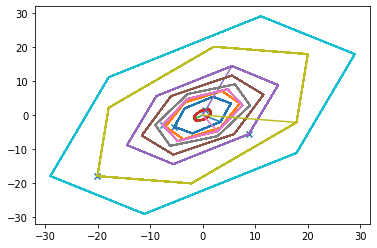

In [ ]:
T = 100
B = 5

c1 = 1# + 1e-2
c2 = 1# - 1e-2
c3 = 1# + 1e-2
A = np.array([[c1, -c2],
              [c3, 0]])
A = np.transpose(A)

def f(x):
    return x @ A + np.random.normal(scale=0.0, size=(B, 2))

x_seq = np.zeros((B, T, 2))
y_seq = np.zeros((B, T, 2))
x0 = np.random.normal(scale=10, size=(B,2))
x_seq[:,0] = x0

for t in tqdm.tqdm(range(1, T-1)):
    x_seq[:, t, :] = f(x_seq[:, t-1, :])

Bmatinv = np.array([[1 + (3**0.5)*1j,  1 - (3**0.5)*1j],
                 [2,              2             ]])
Lambda = np.array([(1+(3**0.5)*1j)/2, (1-(3**0.5)*1j)/2])
Bmat = np.array([[-((3**0.5)/6)*1j, (3+(3**0.5))/12],
              [ ((3**0.5)/6)*1j, (3-(3**0.5))/12]])

for b in range(B):
    for t in tqdm.tqdm(range(T)):
        y_seq[b, t, :] = (Bmatinv 
                          @ np.diag(Lambda**t) 
                          @ Bmat 
                          @ x0[b, :][:, None]
                          )[:, 0].real

plt.scatter(x0[:, 0], x0[:, 1], marker='x', linewidths=10)
for b in range(B):
    plt.plot(x_seq[b, :, 0], x_seq[b, :, 1])
    plt.plot(y_seq[b, :, 0], y_seq[b, :, 1])

#display(x_seq[:, ::10, :])

plt.show()

### Beta-rolling mean smoothed differential approximation

100%|██████████| 998/998 [00:00<00:00, 50425.43it/s]


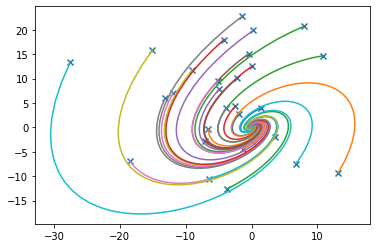

In [ ]:
T = 1000
B = 30

c1 = 1# + 1e-2
c2 = 1# - 1e-2
c3 = 1# + 1e-2
A = np.array([[c1, -c2],
              [c3, 0]])
A = np.transpose(A)

def f(x):
    return x @ A + np.random.normal(scale=1e-2, size=(B, 2))

x_seq = np.zeros((B, T, 2))
y_seq = np.zeros((B, T, 2))
x0 = np.random.normal(scale=10, size=(B,2))
x_seq[:,0] = x0

beta = 0.1

for t in tqdm.tqdm(range(1, T-1)):
    x_seq[:, t, :] = beta * f(x_seq[:, t-1, :]) + (1-beta) * x_seq[:, t-1, :]

plt.scatter(x0[:, 0], x0[:, 1], marker='x', linewidths=10)
for b in range(B):
    plt.plot(x_seq[b, :, 0], x_seq[b, :, 1])

#display(x_seq[:, ::10, :])

plt.show()

## Intelligence Space Model

The intelligence space $I$ is the sparsely occupied space spanning all possible intelligences. Empty regions correspond to inconsitant intelligences. Each point  $x\in I$ corresponds with a particular mode of though or pattern. (This model assumes intelligence is a special form of information that catalyzes information processing)

The intelligence space model uses a lot of heuristics:
- your interest in a topic is porportional to its frequency of occurance
- you're interested in learning things that you're aware of but you think you don't know
- curiosity motivates learning which may or may not increase accurate knowledge about a subject
- curiosity about a topic decreases as your subjective understanding increases

which are formalized by the dynamical system:
$$
i_t(x,t) = f(x,t)(c_1i(x,t) - c_2c(x,t))\int f(y,t)(c_1i(y,t) - c_2c(y,t))||x-y||dy \\
c_t(x,t) = c_3\frac{i(x,t)}{d(x)} - c_4f(x,t)c(x,t)(1-p_\theta(x,t)) \\
f(x,t) \sim c_t(x,t) \text{ when $x$ is an action}
$$